### ENCODER-DECODER MODEL USING RNN IN KERAS

In [3]:
from keras.layers import Input, SimpleRNN, Dense
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

##### Load the data

In [9]:
data = pd.read_csv('train_data.csv')
data = data.values

X = data[:, 0]
Y = data[:, 1]

X = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in X])
Y = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in Y])
Y = np.array([np.append([0], y) for y in Y])

X = np.array([np.eye(27)[x] for x in X])
Y = np.array([np.eye(27)[y] for y in Y])

# Load Test data
test_data = pd.read_csv('eval_data.csv')
test_data = test_data.values

X_test = test_data[:,0]
Y_test = test_data[:,1]

X_test = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in X_test])
Y_test = np.array([np.array([ord(c) - ord('a') + 1 for c in s]) for s in Y_test])
Y_test = np.array([np.append([0], y) for y in Y_test])

X_test = np.array([np.eye(27)[x] for x in X_test])
Y_test = np.array([np.eye(27)[y] for y in Y_test])

##### Training

Epoch 1/300
700/700 [==============================] - 4s 4ms/step - loss: 3.1183 - accuracy: 0.0973 - val_loss: 2.9815 - val_accuracy: 0.1299
Epoch 2/300
700/700 [==============================] - 2s 3ms/step - loss: 2.8526 - accuracy: 0.1574 - val_loss: 2.8148 - val_accuracy: 0.1540
Epoch 3/300
700/700 [==============================] - 2s 3ms/step - loss: 2.7244 - accuracy: 0.1732 - val_loss: 2.7469 - val_accuracy: 0.1589
Epoch 4/300
700/700 [==============================] - 2s 3ms/step - loss: 2.6704 - accuracy: 0.1801 - val_loss: 2.7304 - val_accuracy: 0.1566
Epoch 5/300
700/700 [==============================] - 2s 3ms/step - loss: 2.6362 - accuracy: 0.1846 - val_loss: 2.7183 - val_accuracy: 0.1589
Epoch 6/300
700/700 [==============================] - 2s 3ms/step - loss: 2.6045 - accuracy: 0.1938 - val_loss: 2.7052 - val_accuracy: 0.1614
Epoch 7/300
700/700 [==============================] - 3s 4ms/step - loss: 2.5727 - accuracy: 0.2016 - val_loss: 2.6971 - val_accuracy: 0.1641

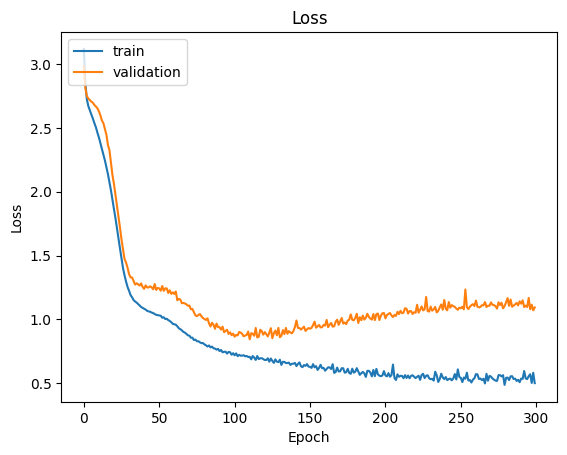

In [12]:
# Training Model
encoder_input = Input(shape=(8, 27))
encoder_rnn = SimpleRNN(128, return_state=True)
encoder_output, encoder_state = encoder_rnn(encoder_input)
encoder_dense = Dense(128, activation='softmax')
encoder_output = encoder_dense(encoder_output)

decoder_input = Input(shape=(None, 27))
decoder_rnn = SimpleRNN(128, return_sequences=True, return_state=True)
decoder_output, _ = decoder_rnn(decoder_input, initial_state=encoder_state)
decoder_dense = Dense(27, activation='softmax')
decoder_output = decoder_dense(decoder_output)

from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# train
history = model.fit([X, Y[:, :-1, :]], Y[:, 1:, :], batch_size=10, epochs=300, validation_data=([X_test, Y_test[:, :-1, :]], Y_test[:, 1:, :]))
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### INFERENCE

In [13]:
# Inference Model
# encoder
encoder_model = Model(encoder_input, encoder_state)

# decoder
decoder_input_h = Input(shape=(128,))
decoder_input_state = [decoder_input_h]
decoder_output, decoder_state = decoder_rnn(decoder_input, initial_state=decoder_input_state)
decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input] + decoder_input_state, [decoder_output, decoder_state])

# saving encoder and decoder
encoder_model.save('encoder2.h5')
decoder_model.save('decoder2.h5')

/home/shravya/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### LOADING THE SAVED MODEL

In [4]:
# Loading the saved model
encoder_model_saved = keras.models.load_model('Best_encoder.h5')
decoder_model_saved = keras.models.load_model('Best_decoder.h5')

In [5]:
# Encoder class
class Encoder:
    def __init__(self, model):
        self.model = model

    def predict(self, input_seq):
        # pre processing input
        input_seq = np.array([np.eye(27)[np.array([ord(c) - ord('a') + 1 for c in input_seq])]])
        state = self.model.predict(input_seq)
        return state

# Decoder class
class Decoder:
    def __init__(self, model):
        self.model = model

    def predict(self, states):
        input = np.array([np.eye(27)[[0]]])
        output = []
        for i in range(8):
            output_tokens, h = self.model.predict([input] + [states])
            output_tokens = output_tokens[0, 0, :]
            index = np.argmax(output_tokens)
            output.append(chr(index + ord('a') - 1))
            input = np.array([np.eye(27)[[index]]])
            states = h
        return ''.join(output)

# predict
encoder = Encoder(encoder_model_saved)
decoder = Decoder(decoder_model_saved)
print(decoder.predict(encoder.predict('sqvuzung')))

1/1 [==============================] - 0s 17ms/step
fdcqaqyx


In [6]:
import pandas as pd
import numpy as np

# Function to check how many characters match in the two strings
def check(pred: str, true: str):
    correct = 0
    for a, b in zip(pred, true):
        if a == b:
            correct += 1

    # Prediction is more than 8 letters, so penalize for every extra letter.
    correct -= max(0, len(pred) - len(true))
    correct = max(0, correct)
    return correct

# Function to score the model's performance
def evaluate(encoder, decoder):

    # Train data
    # print("Obtaining results for training data:")
    # train_data = pd.read_csv("train_data.csv").to_numpy()
    # results = {
    #     "pred": [],
    #     "true": [],
    #     "score": [],
    # }
    # correct = [0 for _ in range(9)]
    # for x, y in train_data:
    #     pred = decoder.predict(encoder.predict(x))
    #     score = check(pred, y)
    #     results["pred"].append(pred)
    #     results["true"].append(y)
    #     results["score"].append(score)

    #     correct[score] += 1
    # print("Train dataset results:")
    # for num_chr in range(9):
    #     print(
    #         f"Number of predictions with {num_chr} correct predictions: {correct[num_chr]}"
    #     )
    # points = sum(correct[4:6]) * 0.5 + sum(correct[6:])
    # print(f"Points: {points}")
    # # Save predicitons and true sentences to inspect manually if required.
    # pd.DataFrame.from_dict(results).to_csv("results_train.csv", index=False)

    #----------------------------------------------------------------------------------

    print("Obtaining metrics for eval data:")
    eval_data = pd.read_csv("eval_data.csv").to_numpy()
    results = {
        "pred": [],
        "true": [],
        "score": [],
    }
    correct = [0 for _ in range(9)]
    for x, y in eval_data:
        pred = decoder.predict(encoder.predict(x))
        score = check(pred, y)
        results["pred"].append(pred)
        results["true"].append(y)
        results["score"].append(score)

        correct[score] += 1
    print("Eval dataset results:")
    for num_chr in range(9):
        print(
            f"Number of predictions with {num_chr} correct predictions: {correct[num_chr]}"
        )
    points = sum(correct[4:6]) * 0.5 + sum(correct[6:])
    marks = round(min(2, points / 1400 * 2) * 2) / 2  # Rounds to the nearest 0.5
    print(f"Points: {points}")
    print(f"Marks: {marks}")
    # Save predicitons and true sentences to inspect manually if required.
    pd.DataFrame.from_dict(results).to_csv("results_eval.csv", index=False)


evaluate(encoder, decoder)


Obtaining metrics for eval data:
1/1 [==============================] - 0s 60ms/step
Eval dataset results:
Number of predictions with 0 correct predictions: 7
Number of predictions with 1 correct predictions: 67
Number of predictions with 2 correct predictions: 230
Number of predictions with 3 correct predictions: 435
Number of predictions with 4 correct predictions: 540
Number of predictions with 5 correct predictions: 447
Number of predictions with 6 correct predictions: 200
Number of predictions with 7 correct predictions: 63
Number of predictions with 8 correct predictions: 11
Points: 767.5
Marks: 1.0
